# 1. Boston 주택 가격 예측 모델

### 데이터셋 feature<br>
- CRIM : 자치시별 1인당 범죄율
- ZN : 25,000 평방피트를 초과하는 거주지역의 비율
- INDUS : 비소매상업지역이 점유하고 있는 토지의 비율
- CHAS : 찰스강에 대한 더미변수(강의 경계에 위치한 경우는 1, 아니면 0)
- NOX : 10ppm 당 농축 일산화질소
- RM : 주택 1 가구당 평균 방의 개수
- AGE : 1940년 이전에 건축된 소유주택의 비율
- DIS : 5개의 보스턴 직업센터까지의 접근성 지수
- RAD : 방사형 도로까지의 접근성 지수
- TAX : 10,000 달러당 재산세율
- PTRATIO : 자치시(town)별 학생/교사 비율
- B : $1000(B_{k}-0.63)^2$, 여기서 $B_{k}$는 자치시별 흑인의 비율을 말함
- LSTAT : 모집단의 하위계층의 비율(%)
- MEDV : 본인 소유의 주택가격(중앙값)(단위: $1,000)

여기서 드는 생각<br>
1. CRIM이 높을수록 MEDV(주택가격)가 낮을 것이다.
2. INDUS 값이 높을수록 MEDV가 낮을 것이다.
3. CHAS 값이 1이면 MEDV가 낮을 것이다.
4. NOX 값이 높을수록 MEDV가 낮을 것이다.
5. DIS 값이 높을수록 MEDV가 높을 것이다.

일단 노드 흐름을 따라가보기로 했다.

## 데이터 로드 및 전처리

In [1]:
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
# keras.datasets 안에 boston_housing 데이터셋을 로드합니다.
from keras.datasets import boston_housing

(train_data, train_labels), (test_data, test_labels) = boston_housing.load_data()

# 데이터셋의 크기를 확인합니다.
print(len(train_data))
print(len(test_data))

65536/57026 [==================================] - 0s 0us/step
404
102


In [3]:
# 문제 1-1: 데이터셋의 전처리를 위해 표준화 작업을 수행합니다.
# 먼저 입력 데이터의 각 특성의 평균을 뺍니다.
mean = train_data.mean(axis=0)
train_data -= mean

# 평균을 뺀 입력 데이터에서 표준편차를 나눕니다.
# 데이터 특성의 중앙이 0에 가깝게 만들고, 표준편차가 1이 되게 만듭니다.
std = train_data.std(axis=0)
train_data /= std

# 테스트 데이터셋도 마찬가지로 평균을 빼고, 표준편차로 나눕니다.
test_data -= mean
test_data /= std

데이터를 표준화해주는 이유는 다음과 같다.<br>
- 데이터의 스케일 차이를 조정함으로써, 모델이 가중치를 학습할 때 각 특성이 동등하게 고려될 수 있다.
- 딥러닝 일부 알고리즘에서는 입력 데이터가 정규분포를 따르는 것을 가정하고 있다. 표준화를 통해 이 가정에 더 가까워질 수 있다.
- 표준화를 통해 이상치의 영향을 줄일 수 있다.<br>

이러한 이유로 데이터셋 내 각 특성들의 스케일 차이를 조정하고, 각 특성들이 동등한 스케일을 가지도록 하는 작업을 해주는 것이다.

한편 딥러닝에서는 머신러닝에서처럼 데이터 시각화가 필요없는건가...?<br>
일단 쿨하게 전처리부터 하고 보니까 따라가보자.

## 모델 구성 및 컴파일

In [4]:
# 문제 1-2: 주택 가격 예측을 위한 딥러닝 모델 구성 및 컴파일합니다.
# input_shape은 (train_data.shape[1], )으로 구성합니다.
# 회귀(예측)을 위한 모델이므로 loss를 mse, metrics를 mae로 사용합니다.
from tensorflow.keras import optimizers
from tensorflow.keras import initializers

# Sequential 모델 사용
model = models.Sequential()

# He 초기값 설정
he = initializers.he_normal()

# 입력층(Dense) 추가
model.add(layers.Dense(64, activation='relu', kernel_initializer=he, input_shape=(train_data.shape[1],)))

# 은닉층(Dense) 추가
model.add(layers.Dense(64, activation='relu', kernel_initializer=he))

# 출력층(Dense) 추가
model.add(layers.Dense(1))

# 모델을 컴파일합니다. 손실 함수는 mse를 사용하고, 성능 지표는 mae를 사용
model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# 모델 구조 보기
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                896       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 5,121
Trainable params: 5,121
Non-trainable params: 0
_________________________________________________________________


노드에서 Sequential() 함수를 이용하여 모델을 구성하라고 해서 Dense layer를 이용하여 구성했다.<br>
활성화 함수도 일단 국룰인 relu를 활용했고, 이와 함께 비선형 함수에 용이한 가중치 초기화 방법인<br>
He 초기값 코드를 찾아 대입했다. (고마워요 밑시딥)<br>
보통 회귀 문제를 딥러닝에 적용해보면 입력값을 통해 출력값을 바로 산출한다고 해서 층수는 최소화했다.<br>
최적화 기법도 국룰인 Adam을 활용했고, 손실 함수와 성능 지표는 노드에서 일러준대로<br>
각각 MSE와 MAE 지표를 활용했다.

## 모델 학습

In [5]:
# 문제 1-3: 예측을 위한 딥러닝 모델을 학습합니다.
from keras.callbacks import EarlyStopping, ModelCheckpoint

# 콜백 함수 설정
early_stop = EarlyStopping(monitor='val_loss', patience=20)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

# 모델 학습
history = model.fit(train_data, train_labels, epochs=1000, batch_size=33,
                    validation_split=0.25,
                    callbacks=[early_stop, model_checkpoint])

Epoch 1/1000
10/10 [==============================] - 1s 18ms/step - loss: 480.9220 - mae: 19.8915 - val_loss: 554.0823 - val_mae: 21.2374
Epoch 2/1000
10/10 [==============================] - 0s 4ms/step - loss: 389.6864 - mae: 17.5420 - val_loss: 453.9841 - val_mae: 18.9087
Epoch 3/1000
10/10 [==============================] - 0s 4ms/step - loss: 303.3909 - mae: 15.0613 - val_loss: 355.2581 - val_mae: 16.3021
Epoch 4/1000
10/10 [==============================] - 0s 4ms/step - loss: 225.3351 - mae: 12.5075 - val_loss: 260.1480 - val_mae: 13.5232
Epoch 5/1000
10/10 [==============================] - 0s 4ms/step - loss: 153.1070 - mae: 9.9736 - val_loss: 179.8094 - val_mae: 10.6300
Epoch 6/1000
10/10 [==============================] - 0s 4ms/step - loss: 102.4753 - mae: 7.9553 - val_loss: 121.2684 - val_mae: 8.2541
Epoch 7/1000
10/10 [==============================] - 0s 4ms/step - loss: 72.7217 - mae: 6.5493 - val_loss: 90.8589 - val_mae: 6.9985
Epoch 8/1000
10/10 [====================

Adam을 사용할 때 학습률을 0.001로 낮게 잡았기 때문에 epoch 횟수를 1000으로 높게 잡았고,<br>
배운 콜백 함수 두 개는 즉각 적용했다.<br>
train_data 개수가 404개여서 검증 데이터는 $\frac{1}{4}$값인 0.25로 잡았다.<br>
시각화까지 드가자~

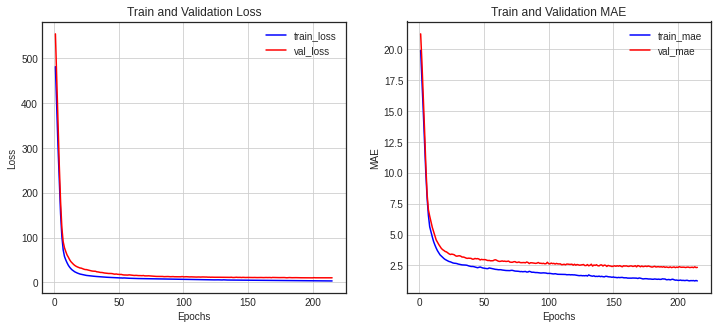

In [7]:
# 모델 학습 히스토리에서 loss, val_loss, mae, val_mae를 차트로 보여줍니다.
plt.style.use('seaborn-white')

history_dict = history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, 'b-', label='train_loss')
ax1.plot(epochs, val_loss, 'r-', label='val_loss')
ax1.set_title('Train and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()

mae = history_dict['mae']
val_mae = history_dict['val_mae']

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, mae, 'b-', label='train_mae')
ax2.plot(epochs, val_mae, 'r-', label='val_mae')
ax2.set_title('Train and Validation MAE')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('MAE')
ax2.grid()
ax2.legend()

plt.show()

시각화 코드는 다행히(?) 프로젝트 노드에서도 제공해줬다.<br>
epoch을 거듭할수록 손실 값도 0에 수렴하고, MAE 지표도 2.5점 이하로 내려간 양상을 볼 수 있으며,<br>
train_mae와 val_mae간 차이도 많이 크지 않아서 학습이 잘 된 편이라고 생각한다.<br>
더 손 볼 곳이 있다면 train_mae와 val_mae 값의, patience를 적용했을 때의 차이를 지금보다 줄여보는 것이다.<br>
하지만 Boston 주택 가격 예측 모델 말고도 해볼 것이 또 있으니, 그것부터 손 봐놓고 마저 손봐야겠다.

## 모델 평가 및 예측

In [8]:
# 문제 1-4: 테스트 데이터셋을 이용해 모델을 평가합니다.
test_loss, test_mae = model.evaluate(test_data, test_labels)
print('Test MAE:', test_mae)

4/4 [==============================] - 0s 2ms/step - loss: 18.5261 - mae: 2.9088
Test MAE: 2.908830165863037


train_data에서 뽑은 MAE 값이 1.2490, validation_data에서 뽑은 MAE 값이 2.3453,<br>
test_data에서 뽑은 MAE 값이 2.9088이다.<br>
사실 MAE 값이 서로 모두 같다면 그것이 제일 이상적이겠지만, train_data와 test_data 간 차이도<br>
많이 나지 않는다고 생각한다. 물론 더 경험해봐야 알 것 같다.

# 2. Reuters 딥러닝 모델

(Boston 모델과 변수명이 겹치는데, 주피터 노트북을 Close and Halt 한 후 따로 실행했다.)

프로젝트에서 제시해 준 tip은 다음과 같다.<br>
> 이번 스텝에서는 8번 노드에 나왔던 모델과 동일한 모델을 실습합니다. 하지만 다양한 성능 향상 방법을 사용하여 8번 노드에서의 딥러닝 모델보다 성능을 더 높일 수 있습니다. 8번 노드에서 사용했던 ReLU와는 다른 활성화함수를 사용해보고, BatchNormalization과 Dropout을 적용해 봅시다. ModelCheckpoint와 EarlyStopping 콜백 함수도 적용해 보세요.

이번엔 ReLU와 다른 활성화 함수를 사용해보고, BatchNormalization과 Dropout도 적용해봐야겠다.

## 데이터 로드 및 전처리

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras import models, layers
from tensorflow.keras import callbacks
from tensorflow.keras import utils
from keras.datasets import reuters

In [2]:
# 문제 2-1: reuters 데이터셋을 로드하고, 훈련 데이터셋에서 25%를 검증 데이터셋으로 분리합니다.
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.25, random_state=2023)

# 훈련, 검증, 테스트 데이터와 레이블 종류가 몇 개인지 출력합니다.
print(len(train_data))
print(len(val_data))
print(len(test_data))
print(len(set(train_labels)))

6736
2246
2246
46


In [3]:
# 문제 2-2: 텍스트 데이터의 전처리를 위해서 각 데이터셋마다 원-핫 인코딩을 수행합니다.
def one_hot_encoding(data, dim=10000):
    results = np.zeros((len(data), dim))
    for i, sequence in enumerate(data):
        results[i, sequence] = 1
    return results

x_train = one_hot_encoding(train_data)
x_val = one_hot_encoding(val_data)
x_test = one_hot_encoding(test_data)

# 레이블 데이터들은 범주형 형태로 to_categorical() 함수를 사용해 변환합니다.
num_classes = len(set(train_labels))
y_train = utils.to_categorical(train_labels, num_classes)
y_val = utils.to_categorical(val_labels, num_classes)
y_test = utils.to_categorical(test_labels, num_classes)

x_train = one_hot_encoding(train_data)<br>
x_val = one_hot_encoding(val_data)<br>
x_test = one_hot_encoding(test_data)<br><br>
이와 같이 원-핫 인코딩을 사용하면 모델이 단어 간의 유사도를 쉽게 계산하고<br>
문서 분류 및 텍스트 생성과 같은 자연어 처리 작업에 사용할 수 있다.<br>
또한<br><br>
y_train = utils.to_categorical(train_labels, num_classes)<br>
y_val = utils.to_categorical(val_labels, num_classes)<br>
y_test = utils.to_categorical(test_labels, num_classes)<br><br>
와 같이 코딩해주면 Reuters 모델 구축이 다중 분류 문제에 속하므로 출력층에서 softmax 함수를 사용할 수 있게 된다.<br>
각 클래스에 대한 확률 값을 계산할 수 있고, 원-핫 인코딩된 레이블과 모델의 예측값이 일치할 경우에만<br>
정확도 지표가 상승하므로 Reuters 모델에 적합한 전처리 방식은 원-핫 인코딩이라 볼 수 있다.

## 모델 구성 및 컴파일

In [4]:
# 문제 2-3: 빠른 학습과 과대적합을 방지하기 위해 BatchNormalization과 Dropout을 적용한 딥러닝 모델을 구성합니다.
from tensorflow.keras import initializers

# Xavier 초기값 설정
xavier = initializers.glorot_normal()

# 모델 구축
model = models.Sequential([
    layers.Dense(128, activation='sigmoid', kernel_initializer=xavier, input_shape=(10000,)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='sigmoid', kernel_initializer=xavier),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(46, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1280128   
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 46)                5

활성화함수로 ReLU가 아닌 Sigmoid 함수를 사용했고, 그에 맞는 가중치 초기화 방식인 Xavier 초기값을 채택했다.<br>
배치 정규화와 Dropout(50%)을 적용하여 과대적합을 방지하고자 했고,<br>
출력층에는 다중 분류 방식에 적합한 함수인 Softmax 활성화함수를 적용했다.

## 모델 학습

In [5]:
# 문제 2-4: ModelCheckpoint와 EarlyStopping 콜백 함수를 적용하여 모델 학습을 진행합니다.
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import optimizers

# ModelCheckpoint 콜백 함수 생성
mc_callback = callbacks.ModelCheckpoint('best_model2.h5', monitor='val_loss', save_best_only=True)

# EarlyStopping 콜백 함수 생성
es_callback = callbacks.EarlyStopping(monitor='val_loss', patience=10)

# 모델 컴파일
model.compile(optimizer=optimizers.Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

# 모델 학습
history = model.fit(x_train, y_train, epochs=50, batch_size=256, validation_data=(x_val, y_val), callbacks=[mc_callback, es_callback])

Epoch 1/50
27/27 [==============================] - 2s 30ms/step - loss: 1.8211 - accuracy: 0.6379 - val_loss: 2.5123 - val_accuracy: 0.5913
Epoch 2/50
27/27 [==============================] - 0s 10ms/step - loss: 0.8807 - accuracy: 0.7982 - val_loss: 1.9321 - val_accuracy: 0.4809
Epoch 3/50
27/27 [==============================] - 0s 10ms/step - loss: 0.5842 - accuracy: 0.8658 - val_loss: 1.6063 - val_accuracy: 0.5436
Epoch 4/50
27/27 [==============================] - 0s 10ms/step - loss: 0.4318 - accuracy: 0.8971 - val_loss: 1.4018 - val_accuracy: 0.5984
Epoch 5/50
27/27 [==============================] - 0s 10ms/step - loss: 0.3215 - accuracy: 0.9227 - val_loss: 1.2582 - val_accuracy: 0.6318
Epoch 6/50
27/27 [==============================] - 0s 10ms/step - loss: 0.2777 - accuracy: 0.9298 - val_loss: 1.2356 - val_accuracy: 0.6665
Epoch 7/50
27/27 [==============================] - 0s 10ms/step - loss: 0.2455 - accuracy: 0.9381 - val_loss: 1.1110 - val_accuracy: 0.7213
Epoch 8/50
27

Boston 모델과 마찬가지로 callback 함수 두 개를 적용했고, val_loss값을 기준으로<br>
10회 동안 성능 향상이 이루어지지 않을 경우 학습을 중단하도록 설정했다.<br>
최적화 기법으로 Adam을 채용했고, 학습률은 0.01로 설정했다.<br>
다중 클래스 분류 문제에서 주로 사용되는 categorical_crossentropy를 손실함수로 정했고,<br>
평가 지표는 정확도로 설정했다.<br>
수행한 학습에 대해 시각화를 적용해보자.

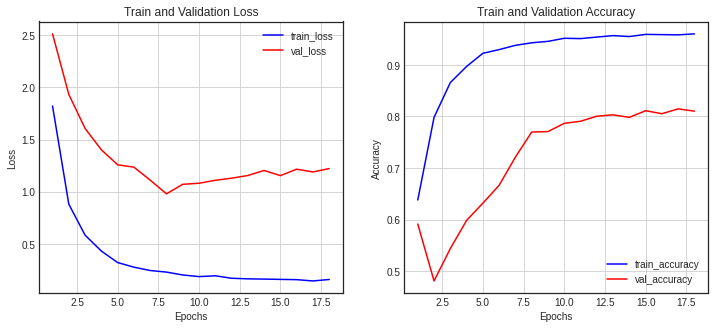

In [6]:
# 학습 히스토리의 `loss`, `val_loss`, `accuracy`, `val_accuracy`를 차트로 시각화합니다.
plt.style.use('seaborn-white')

history_dict = history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, 'b-', label='train_loss')
ax1.plot(epochs, val_loss, 'r-', label='val_loss')
ax1.set_title('Train and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()

accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, accuracy, 'b-', label='train_accuracy')
ax2.plot(epochs, val_accuracy, 'r-', label='val_accuracy')
ax2.set_title('Train and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.grid()
ax2.legend()

plt.show()

train_loss 그래프는 매끄러운 우하향 곡선인 반면<br>
val_loss 그래프는 우하향하다가 약간 솟는 양상을 보여준다.<br>
또한 train_accuracy 그래프는 정확도가 1에 수렴하는 반면<br>
val_accuracy 그래프는 그에 못미치는 정확도를 보여준다.<br>
과대적합을 방지하기 위해 배치 정규화와 Dropout(50%)을 적용해봤지만<br>
그럼에도 불구하고 과대적합이 일어났음을 보여주는 그래프인 것 같다.

## 모델 평가 및 예측

In [7]:
# 문제 2-5: 테스트 데이터셋을 이용해 모델을 평가합니다.
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'Test accuracy: {test_acc}')

71/71 [==============================] - 0s 3ms/step - loss: 1.3472 - accuracy: 0.7965
Test accuracy: 0.7965271472930908


값을 정리해볼 필요가 있을 것 같다.<br>
- train accuracy : 0.9604, train loss : 0.1596 (마지막 epoch 값)
- val accuracy : 0.8103, val loss : 1.2219 (마지막 epoch 값)
- test accuracy : 0.7965<br>

훈련 데이터 정확도와 검증/테스트 데이터 정확도 간 차이가 0.1이다.<br>
정확도 지표가 0과 1사이의 값을 나타낸다는 점을 고려하면 유의미한 차이라고 생각한다.<br>
과대적합 방지책을 썼지만, 조금 더 하이퍼파라미터 값들을 조정해줘야 될 것 같다.<br>
이따가.

# CIFAR10 딥러닝 모델

CIFAR10 데이터셋은 32x32 픽셀의 6,000개 컬러 이미지로 이루어져 있다. 데이터셋의 각 이미지는 10개의 클래스로 라벨링 되어있다.

## 데이터 로드 및 전처리

In [1]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras import models, layers
from tensorflow.keras.datasets import cifar10

In [2]:
# 문제 3-1: cifar10 데이터셋을 로드하고, 훈련 데이터셋에서 20%를 검증 데이터셋으로 분리합니다.
(x_train_full, y_train_full), (x_test, y_test) = cifar10.load_data()

x_train, x_val, y_train, y_val = train_test_split(x_train_full, y_train_full, test_size=0.2, random_state=2023)

# 훈련, 검증, 테스트 데이터와 레이블 종류가 몇개인지 출력합니다.
print("전체 학습 데이터: {} 레이블: {}".format(x_train_full.shape, y_train_full.shape))
print("학습 데이터: {} 레이블: {}".format(x_train.shape, y_train.shape))
print("검증 데이터: {} 레이블: {}".format(x_val.shape, y_val.shape))
print("테스트 데이터: {} 레이블: {}".format(x_test.shape, y_test.shape))

# 훈련, 검증, 테스트 데이터와 레이블 종류가 몇개인지 출력합니다.
num_classes = 10

# 레이블 데이터들은 범주형 형태로 to_categorical() 함수를 사용해 변환합니다.
from keras.utils.np_utils import to_categorical

y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)
y_test = to_categorical(y_test, num_classes)

170508288/170498071 [==============================] - 4s 0us/step
전체 학습 데이터: (50000, 32, 32, 3) 레이블: (50000, 1)
학습 데이터: (40000, 32, 32, 3) 레이블: (40000, 1)
검증 데이터: (10000, 32, 32, 3) 레이블: (10000, 1)
테스트 데이터: (10000, 32, 32, 3) 레이블: (10000, 1)


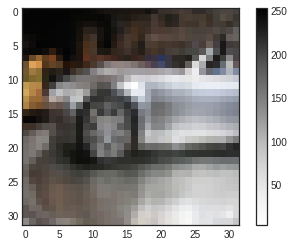

In [3]:
# 훈련 데이터의 0번째인 x_train[0]를 이미지로 시각화합니다.
plt.style.use('seaborn-white')

plt.figure()
plt.imshow(x_train[0])
plt.colorbar()
plt.show()

In [4]:
# 훈련, 검증, 테스트 데이터의 형태(shape)을 출력합니다.
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(40000, 32, 32, 3)
(10000, 32, 32, 3)
(10000, 32, 32, 3)


In [5]:
# 문제 3-2: 훈련, 검증, 테스트 데이터의 형태(shape)을 32 * 32 * 3 = 3072로 변형합니다.
x_train = x_train.reshape((40000, 3072))
x_val = x_val.reshape((10000, 3072))
x_test = x_test.reshape((10000, 3072))

print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(40000, 3072)
(10000, 3072)
(10000, 3072)


In [6]:
# 훈련, 검증, 테스트 데이터를 255로 나누어 0~1 사이의 값으로 변환합니다.
x_train = x_train / 255.
x_val = x_val / 255.
x_test = x_test / 255.

## 모델 구성 및 컴파일

In [7]:
# 문제 3-3: BatchNormalization과 Dropout을 적용하여 빠른 학습과 과대적합을 방지하고,
# 10개의 이미지를 분류하는 딥러닝 모델을 구성합니다.
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import initializers

# He 초기값 설정
he = initializers.he_normal()

model = Sequential([
    Dense(2048, activation='relu', kernel_initializer=he, input_shape=(3072,)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1024, activation='relu', kernel_initializer=he),
    BatchNormalization(),
    Dropout(0.5),
    Dense(512, activation='relu', kernel_initializer=he),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu', kernel_initializer=he),
    BatchNormalization(),
    Dropout(0.5),
    # 출력 레이어를 추가합니다. 클래스는 10개입니다.
    Dense(10, activation='softmax')
])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2048)              6293504   
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4096      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               5

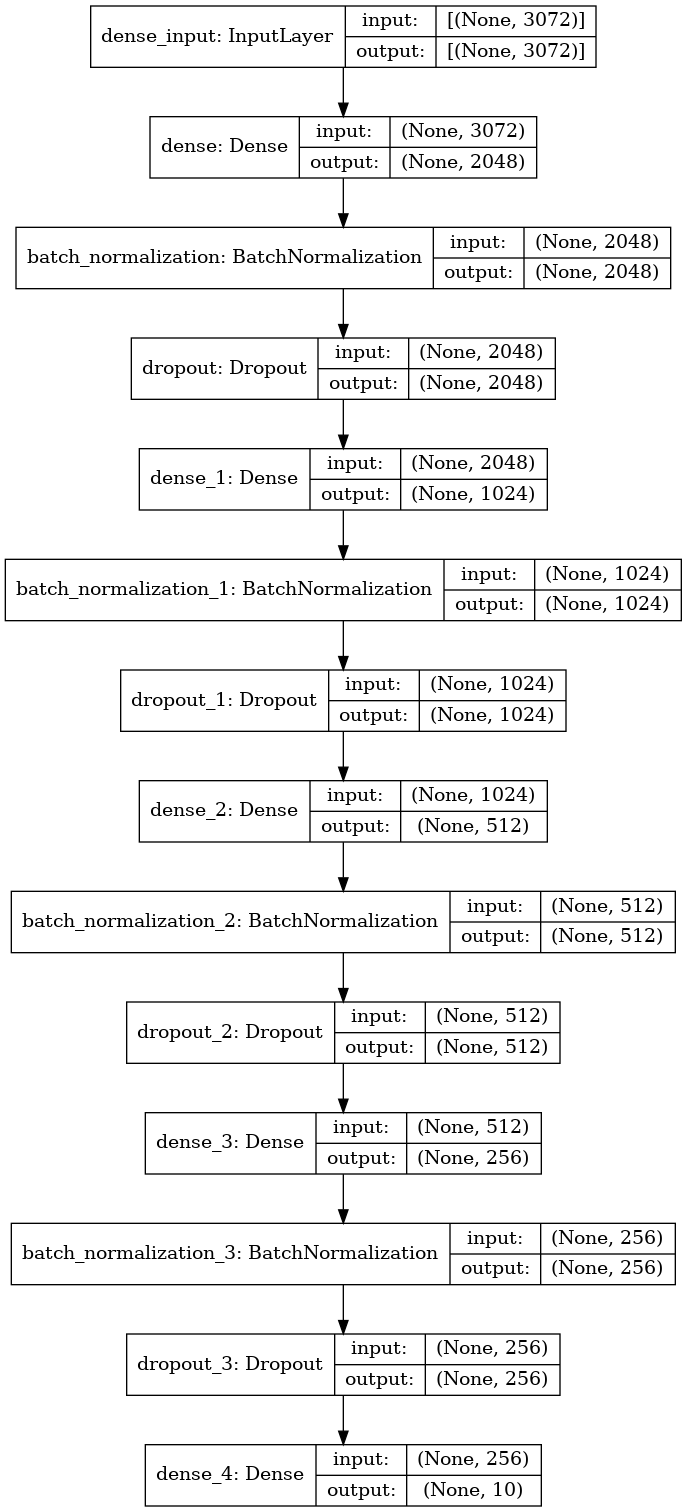

In [9]:
from tensorflow.keras import utils
utils.plot_model(model, show_shapes=True)

## 모델 학습

In [10]:
# 문제 3-4: ModelCheckpoint와 EarlyStopping 콜백 함수를 적용하여 모델 학습을 진행합니다.
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import optimizers

# ModelCheckpoint 콜백 함수
checkpoint_path = "best_model3.h5"
checkpoint = ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_accuracy')

# EarlyStopping 콜백 함수
earlystop = EarlyStopping(monitor='val_accuracy', patience=10)

# 모델 컴파일
model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# 모델 학습
history = model.fit(x_train, y_train, epochs=1000, batch_size=128, validation_data=(x_val, y_val), callbacks=[checkpoint, earlystop])

Epoch 1/1000
313/313 [==============================] - 5s 10ms/step - loss: 2.3671 - accuracy: 0.2405 - val_loss: 1.8467 - val_accuracy: 0.3233
Epoch 2/1000
313/313 [==============================] - 2s 7ms/step - loss: 1.8818 - accuracy: 0.3230 - val_loss: 1.7726 - val_accuracy: 0.3572
Epoch 3/1000
313/313 [==============================] - 2s 7ms/step - loss: 1.7550 - accuracy: 0.3717 - val_loss: 1.8295 - val_accuracy: 0.3354
Epoch 4/1000
313/313 [==============================] - 2s 7ms/step - loss: 1.7095 - accuracy: 0.3887 - val_loss: 1.6892 - val_accuracy: 0.3892
Epoch 5/1000
313/313 [==============================] - 2s 7ms/step - loss: 1.6844 - accuracy: 0.3965 - val_loss: 1.7224 - val_accuracy: 0.3848
Epoch 6/1000
313/313 [==============================] - 2s 7ms/step - loss: 1.6701 - accuracy: 0.4033 - val_loss: 1.6650 - val_accuracy: 0.4013
Epoch 7/1000
313/313 [==============================] - 2s 7ms/step - loss: 1.6596 - accuracy: 0.4036 - val_loss: 1.7688 - val_accuracy

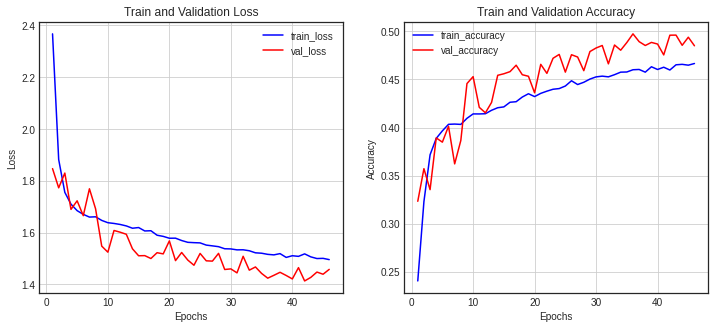

In [11]:
# 문제 3-5: 학습 히스토리의 `loss`, `val_loss`, `accuracy`, `val_accuracy`를 차트로 시각화합니다.
plt.style.use('seaborn-white')

history_dict = history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, 'b-', label='train_loss')
ax1.plot(epochs, val_loss, 'r-', label='val_loss')
ax1.set_title('Train and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()

accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, accuracy, 'b-', label='train_accuracy')
ax2.plot(epochs, val_accuracy, 'r-', label='val_accuracy')
ax2.set_title('Train and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.grid()
ax2.legend()

plt.show()

## 모델 평가 및 예측

In [12]:
# 테스트 데이터셋을 이용해 모델을 평가합니다.
model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 1.4509 - accuracy: 0.4823


[1.4509005546569824, 0.4823000133037567]

전반적으로 손실 값이 줄어드는 모양을 보이고 있지만<br>
학습이 끝난 시점에서도 손실 값이 1 이상이고<br>
정확도도 0.5 미만의 수치를 보여준다.<br>
아무래도 Sequential() 함수의 Dense layer는 이미지를 훈련시키는 데에 부적합해 보인다.<br><br>
CNN layer를 공부하여 다시 적용해보면 의미있는 결과를 얻을 수 있지 않을까?